In [1]:
import torch
import torch.nn as nn
from utils import train
from bin_packing_dataset import BinPackingDataset
from torch.utils.data import random_split

In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

NUM_WORKERS = 0 # max(os.cpu_count() - 1, 1)  # número de workers para cargar los datos


print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Device: mps
Num Workers: 0


### Exploración del Dataset

In [4]:
#Creacion del dataset de entrenamiento, validacion y test

full_dataset = BinPackingDataset('data')
print('Full dataset size:', len(full_dataset))
container_tensor, boxes_tensor = full_dataset[0]
print('Container:', container_tensor)
print('Boxes:', boxes_tensor)

train_dataset, val_dataset = random_split(full_dataset, [int(0.8*len(full_dataset)), int(0.20*len(full_dataset))])
print('Train dataset size:', len(train_dataset))
print('Val dataset size:', len(val_dataset))

Full dataset size: 81000
Container: tensor([14., 11.])
Boxes: tensor([[ 8.,  7.],
        [12.,  2.],
        [ 1.,  2.],
        [ 2.,  7.],
        [ 4.,  8.],
        [ 0.,  0.]])
Train dataset size: 64800
Val dataset size: 16200


In [5]:
# Collate para manejar secuencias de diferentes longitudes
import torch.nn.utils.rnn as rnn_utils

def custom_collate_fn_with_padding(batch):
    """
    Collate function que mantiene la estructura de contenedor y agrega padding a las secuencias de cajas.
    
    Args:
        batch (list): Lista de tuplas (contenedor, cajas).
        
    Returns:
        tuple: (contenedores, cajas_padded, longitudes) donde:
            - contenedores: Tensor de tamaño (batch_size, 2).
            - cajas_padded: Tensor de tamaño (batch_size, max_len, 2) con padding.
            - longitudes: Tensor de tamaños originales de las secuencias de cajas.
    """
    containers = torch.stack([item[0] for item in batch])  # Contenedores como tensor
    boxes = [item[1] for item in batch]  # Lista de cajas
    
    # Padding de las secuencias de cajas (rellenar con ceros hasta la longitud máxima en el batch)
    boxes_padded = rnn_utils.pad_sequence(boxes, batch_first=True)
    
    # Longitudes originales de cada secuencia de cajas
    lengths = torch.tensor([len(b) for b in boxes])
    
    return containers, boxes_padded



BATCH_SIZE = 40000
mock_loader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn_with_padding)

container, target_seq = next(iter(mock_loader))
print('Tamaño del primer contenedor:', container.shape)
print('Tamaño de las cajas del primer contenedor:', target_seq.shape)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn_with_padding)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn_with_padding)

Tamaño del primer contenedor: torch.Size([40000, 2])
Tamaño de las cajas del primer contenedor: torch.Size([40000, 11, 2])


In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class AutoRegressiveBinPackingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, max_dim, n_layers, dropout=0.1):
        super(AutoRegressiveBinPackingModel, self).__init__()
        
        # Embedding para entrada (contenedor y cajas)
        self.embedding = nn.Linear(input_dim, embedding_dim)
        
        # LSTM para modelar secuencias
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )
        
        # Proyección para obtener logits de distribuciones de width y height
        self.fc_width = nn.Linear(hidden_dim, max_dim + 1)  # +1 para incluir el token EOS
        self.fc_height = nn.Linear(hidden_dim, max_dim + 1)
    
    def forward(self, container, target_seq=None, seq_len=100, teacher_forcing_ratio=0.5):
        """
        Args:
            container: Tensor con las dimensiones del contenedor (batch_size, input_dim).
            target_seq: Secuencia objetivo durante entrenamiento (batch_size, seq_len, input_dim).
            seq_len: Longitud máxima de secuencia durante generación.
            teacher_forcing_ratio: Probabilidad de usar teacher forcing (0.0 a 1.0).
        
        Returns:
            Logits para distribuciones de width y height.
        """
        container_emb = self.embedding(container).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        
        # Para almacenar las salidas durante la generación
        outputs_width = []
        outputs_height = []
        
        # Estado inicial
        generated_seq = container_emb
        hidden = None
        
        for t in range(seq_len):
            output, hidden = self.lstm(generated_seq, hidden)  # (batch_size, 1, hidden_dim)
            
            # Logits para width y height
            logits_width = self.fc_width(output[:, -1, :])  # (batch_size, max_dim+1)
            logits_height = self.fc_height(output[:, -1, :])  # (batch_size, max_dim+1)
            outputs_width.append(logits_width)
            outputs_height.append(logits_height)
            
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Usar la secuencia objetivo (teacher forcing)
                next_box = target_seq[:, t, :]  # (batch_size, 2)
            else:
                # Sampleo de la predicción
                prob_width = F.softmax(logits_width, dim=-1)  # (batch_size, max_dim+1)
                prob_height = F.softmax(logits_height, dim=-1)  # (batch_size, max_dim+1)
                next_width = torch.multinomial(prob_width, num_samples=1)  # (batch_size, 1)
                next_height = torch.multinomial(prob_height, num_samples=1)  # (batch_size, 1)
                next_box = torch.cat([next_width, next_height], dim=1)  # (batch_size, 2)
            
            # Preparar la entrada para el siguiente paso
            next_box_emb = self.embedding(next_box.float())  # Convertir a embedding
            # Concatenamos la secuencia generada con la nueva caja
            generated_seq = torch.cat([generated_seq, next_box_emb.unsqueeze(1)], dim=1)
        
        # Apilar las salidas
        logits_width = torch.stack(outputs_width, dim=1)  # (batch_size, seq_len, max_dim+1)
        logits_height = torch.stack(outputs_height, dim=1)  # (batch_size, seq_len, max_dim+1)
        return logits_width, logits_height


In [6]:
#Definimos nuestra propia Loss Function para tener la misma firma en el forward
class BaseBinPackingProblemLoss(nn.Module):
    def __init__(self, max_dim, device):
        super(BaseBinPackingProblemLoss, self).__init__()
        self.max_dim = max_dim
        self.axis_criterion = nn.CrossEntropyLoss()
        self.to(device)
    
    def forward(self, container, logits_width, logits_height, target_seq):
        """
        Args:
            container: Tensor con las dimensiones del contenedor (batch_size, 2).
            logits_width: Logits de la distribución de width (batch_size, seq_len, max_dim+1).
            logits_height: Logits de la distribución de height (batch_size, seq_len, max_dim+1).
            target_seq: Secuencia objetivo (batch_size, seq_len, 2).
        
        Returns:
            Loss.
        """

        # Cross-entropy loss
        target_width = target_seq[:, :, 0].long()  # (batch_size, seq_len)
        target_height = target_seq[:, :, 1].long()  # (batch_size, seq_len)
        loss_width = self.axis_criterion(logits_width.view(-1, self.max_dim+1), target_width.view(-1))
        loss_height = self.axis_criterion(logits_height.view(-1, self.max_dim+1), target_height.view(-1))
        return loss_width + loss_height

In [8]:
# Configuración
from utils import EarlyStopping


MAX_DIM = 20

def evaluate(model, criterion,  data_loader, device, teacher_forcing_ratio):
    """
    Evalúa el modelo en los datos proporcionados y calcula la pérdida promedio.

    Args:
        model (torch.nn.Module): El modelo que se va a evaluar.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        data_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de evaluación.
        device (str): El dispositivo donde se ejecutará el cálculo.
        teacher_forcing_ratio (float): Prop

    Returns:
        float: La pérdida promedio en el conjunto de datos de evaluación.

    """
    model.eval()  # ponemos el modelo en modo de evaluacion
    total_loss = 0  # acumulador de la perdida
    with torch.no_grad():  # deshabilitamos el calculo de gradientes
        for container, target_seq in data_loader:  # iteramos sobre el dataloader
            container = container.to(device)  # movemos los datos al dispositivo
            target_seq = target_seq.to(device)  # movemos los datos al dispositivo
            logits_width, logits_height = model(
                container, 
                target_seq=target_seq, 
                seq_len=target_seq.size(1), 
                teacher_forcing_ratio=teacher_forcing_ratio
            )
            loss = criterion(container, logits_width, logits_height, target_seq).item()
            total_loss += loss  # acumulamos la perdida
    return total_loss / len(data_loader)  # retornamos la perdida promedio

def train(
        model,
        criterion,
        optimizer,
        epochs = 500,
        patience=7,
        teacher_forcing_initial_ratio = 0.5,
        teacher_forcing_decay = 0.95,
        device = DEVICE
        ):
    """
    Entrena un modelo de PyTorch.
    Args:
        model (torch.nn.Module): El modelo que se va a entrenar.
        patience (int): Número de épocas sin mejora antes de detener el entrenamiento.
        teacher_forcing_initial_ratio (float): Proporción de teacher forcing al comenzar el entrenamiento.
    """
    early_stopping = EarlyStopping(patience=patience)
    teacher_forcing_ratio = teacher_forcing_initial_ratio
    for epoch in range(epochs):
        model.train()
        teacher_forcing_ratio *= teacher_forcing_decay  # Reducimos el ratio por cada época
        train_loss = 0
        
        for container, target_seq in train_dataloader:
            container = container.to(device)
            target_seq = target_seq.to(device)
            
            optimizer.zero_grad()
            logits_width, logits_height = model(
                container, 
                target_seq=target_seq, 
                seq_len=target_seq.size(1), 
                teacher_forcing_ratio=teacher_forcing_ratio
            )
            loss = criterion(container, logits_width, logits_height, target_seq)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader)}")
        val_loss = evaluate(model, criterion, val_dataloader, device, teacher_forcing_ratio)
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss}")
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Detener entrenamiento en la época {epoch}, la mejor pérdida fue {early_stopping.best_score:.5f}")
            break



In [ ]:
# Datos de entrenamiento
criterion = BaseBinPackingProblemLoss(MAX_DIM, DEVICE)
input_dim = 2
embedding_dim = 2
hidden_dim = 10
n_layers = 1
dropout = 0

# Modelo
model = AutoRegressiveBinPackingModel(input_dim, embedding_dim, hidden_dim, MAX_DIM, n_layers, dropout)
model.to(DEVICE)
# Hiperparámetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model,criterion, optimizer,epochs=2000)

In [127]:
from models import Box

def generate_sequence(model, container, max_seq_len=10):
    """
    Genera una secuencia de cajas a partir de un contenedor utilizando el modelo.

    Args:
        model: El modelo entrenado para generar secuencias.
        container: Tensor con las dimensiones del contenedor (batch_size=1, input_dim=2).
        max_seq_len: Longitud máxima de la secuencia generada.
        device: Dispositivo (cpu o cuda) donde se ejecutará la inferencia.

    Returns:
        List[Box]: Lista de cajas generadas como instancias de la clase `Box`.
    """
    model.eval()  # Poner el modelo en modo evaluación
    # # Verifica que el contenedor sea bidimensional
    # if container.ndim == 1:
    #     container = container.unsqueeze(0)  # Convertir a (1, input_dim)
    container = container.to(DEVICE)  # (batch_size, input_dim)

    generated_boxes = []  # Lista para almacenar las cajas generadas
    with torch.no_grad():  # Deshabilitar cálculo de gradientes
        logits_width, logits_height = model(container, target_seq=None, seq_len=max_seq_len, teacher_forcing_ratio=0.0)

        for t in range(max_seq_len):
            # Obtener logits del tiempo actual
            prob_width = F.softmax(logits_width[:, t, :], dim=-1)  # (batch_size, max_dim+1)
            prob_height = F.softmax(logits_height[:, t, :], dim=-1)  # (batch_size, max_dim+1)

            # Samplear dimensiones width y height
            sampled_width = torch.multinomial(prob_width, num_samples=1).item()  # Convertir a int
            sampled_height = torch.multinomial(prob_height, num_samples=1).item()  # Convertir a int

            # Crear instancia de Box y agregarla a la lista
            if sampled_width == 0 and sampled_height == 0:  # EOS token
                break
            generated_boxes.append(Box(sampled_width, sampled_height))

    return generated_boxes



In [ ]:
from models import BinPackingGame, ResolvedBinPackingGameResult


container_width = 10
container_height = 10
container = torch.tensor([[container_width, container_height]], dtype=torch.float32)
print(f"{container.shape=}")
generated_seq = generate_sequence(model, container, max_seq_len=10)
game = BinPackingGame(Box(container_width, container_height), generated_seq)
result = game.solve()
if isinstance(result, ResolvedBinPackingGameResult):
    print("La secuencia generada es válida")
    print("Secuencia generada:", generated_seq)
else:
    print("La secuencia generada no es válida")

In [ ]:
from evaluator import Evaluator

evaluator = Evaluator(
    sequence_generator= lambda container, sequence_lenght: generate_sequence(model, torch.tensor([[container.width, container.height]],dtype=torch.float32).to(DEVICE), sequence_lenght),
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()

In [11]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def analyze_metric(results, metric_func, metric_name):
    """
    Analiza los resultados de la evaluación de una métrica específica.
    
    Args:
        results (dict): Diccionario con los resultados de la evaluación.
        metric_func (lambda): Función que nos permite obtener el valor de la métrica de un resultado.
        metric_name (str): Nombre de la métrica.
    """
    results.sort(key=lambda r: metric_func(r), reverse=True)
    print(f"Mejores 5 de {metric_name}:")
    for result in results[:5]:
        print(f'{result.container} - {metric_func(result)}')
    print(f"Peores 5 de {metric_name}:")
    for result in results[-5:]:
        print(f'{result.container} - {metric_func(result)}')

    metrics = [metric_func(result) for result in results]
    widths = [result.container.width for result in results]
    heights = [result.container.height for result in results]

    # Crear gráfico
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(widths, heights, c=metrics, cmap='viridis', s=100, edgecolor='k')

    # Añadir barra de color
    cbar = plt.colorbar(scatter)
    cbar.set_label(metric_name, fontsize=12)

    # Etiquetas y título
    plt.xlabel('Width', fontsize=12)
    plt.ylabel('Height', fontsize=12)
    plt.title(f'{metric_name} for each (Width, Height) pair', fontsize=14)

    # Configurar incrementos de los ejes
    x_ticks = range(min(widths), max(widths) + 1)
    y_ticks = range(min(heights), max(heights) + 1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    # Mostrar gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Mejores 5 de Valid Games Percentage:
Box(width=12, height=18) - 0.8
Box(width=14, height=19) - 0.8
Box(width=10, height=6) - 0.8
Box(width=20, height=17) - 0.8
Box(width=15, height=14) - 0.8
Peores 5 de Valid Games Percentage:
Box(width=6, height=1) - 0.0
Box(width=6, height=2) - 0.0
Box(width=15, height=1) - 0.0
Box(width=1, height=10) - 0.0
Box(width=9, height=7) - 0.0


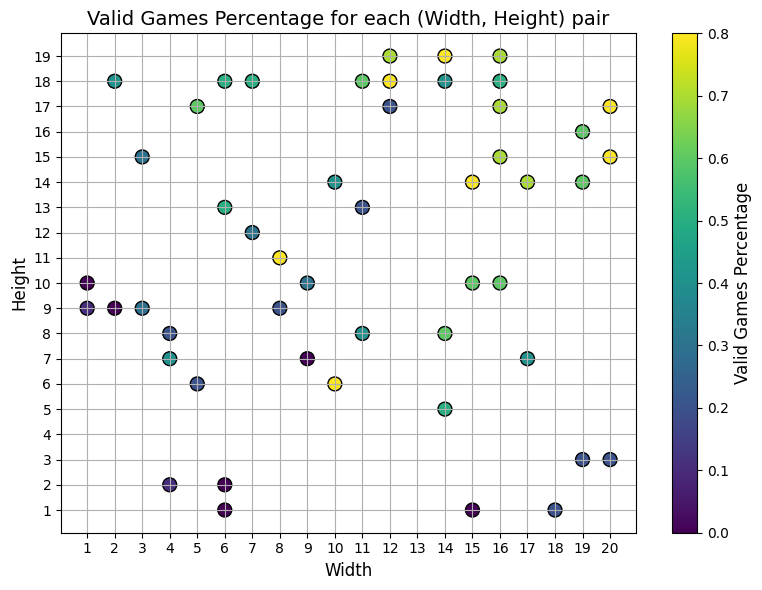

In [117]:
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')

Mejores 5 de Unique Games Percentage:
Box(width=12, height=18) - 0.8
Box(width=14, height=19) - 0.8
Box(width=10, height=6) - 0.8
Box(width=20, height=17) - 0.8
Box(width=15, height=14) - 0.8
Peores 5 de Unique Games Percentage:
Box(width=6, height=1) - 0.0
Box(width=6, height=2) - 0.0
Box(width=15, height=1) - 0.0
Box(width=1, height=10) - 0.0
Box(width=9, height=7) - 0.0


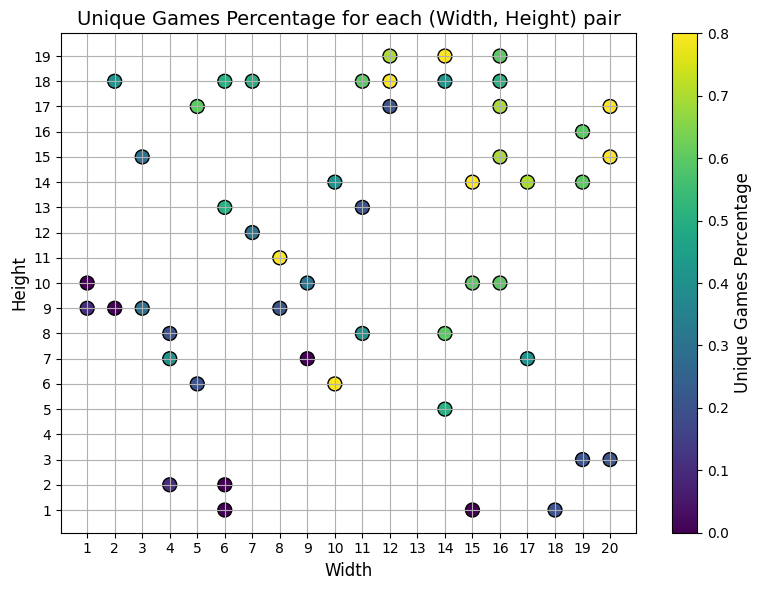

In [118]:
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')

Mejores 5 de New Games Percentage:
Box(width=12, height=18) - 0.8
Box(width=14, height=19) - 0.8
Box(width=10, height=6) - 0.8
Box(width=20, height=17) - 0.8
Box(width=15, height=14) - 0.8
Peores 5 de New Games Percentage:
Box(width=6, height=1) - 0.0
Box(width=6, height=2) - 0.0
Box(width=15, height=1) - 0.0
Box(width=1, height=10) - 0.0
Box(width=9, height=7) - 0.0


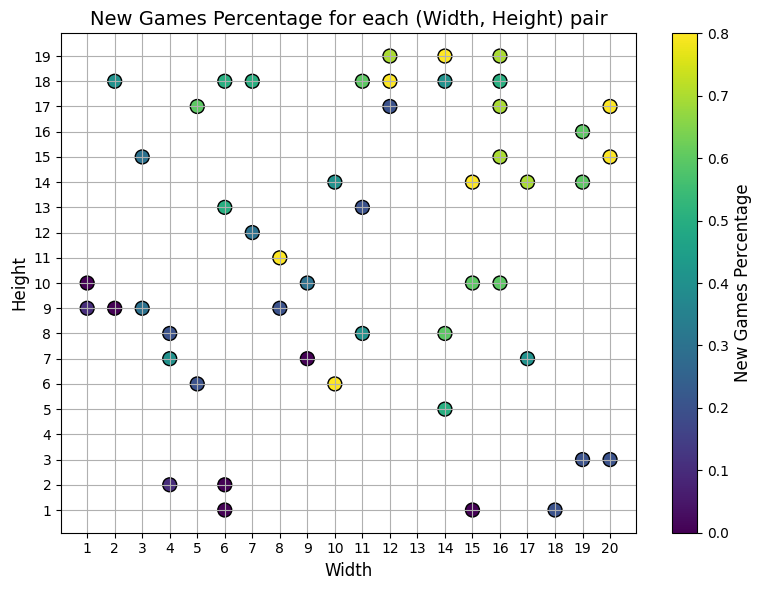

In [119]:
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')

Mejores 5 de Coverage Average:
Box(width=4, height=2) - 1.0
Box(width=11, height=13) - 0.6468531468531469
Box(width=10, height=6) - 0.5625
Box(width=4, height=7) - 0.5
Box(width=14, height=5) - 0.4428571428571429
Peores 5 de Coverage Average:
Box(width=6, height=1) - 0
Box(width=6, height=2) - 0
Box(width=15, height=1) - 0
Box(width=1, height=10) - 0
Box(width=9, height=7) - 0


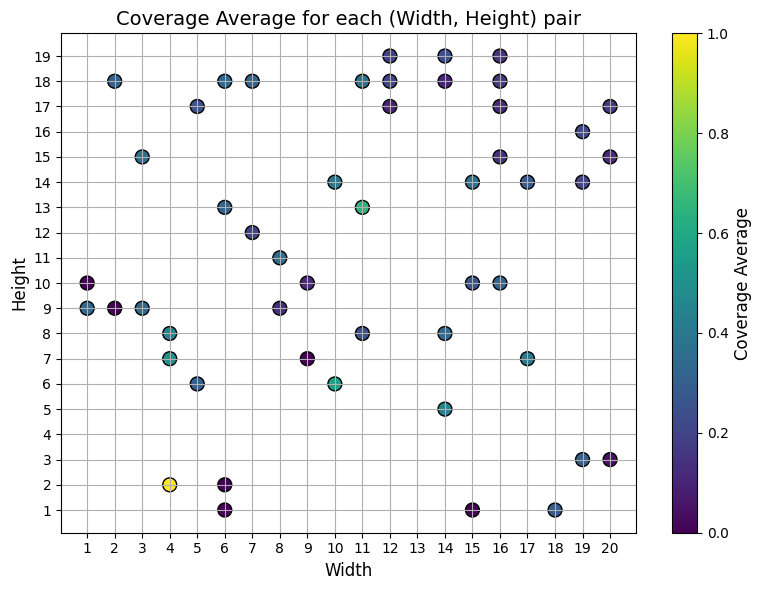

In [120]:
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')

Mejores 5 de Box Count Average:
Box(width=11, height=13) - 5.0
Box(width=17, height=7) - 3.25
Box(width=16, height=18) - 3.2
Box(width=14, height=19) - 3.125
Box(width=11, height=18) - 3.0
Peores 5 de Box Count Average:
Box(width=6, height=1) - 0
Box(width=6, height=2) - 0
Box(width=15, height=1) - 0
Box(width=1, height=10) - 0
Box(width=9, height=7) - 0


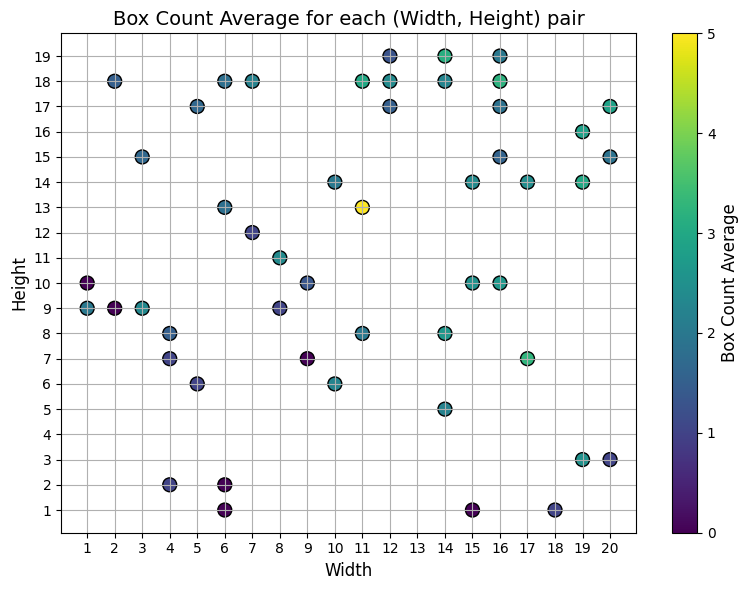

In [121]:
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

In [122]:
# Promedio total de todas las métricas en todas las configuraciones

valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")

Valid Games Percentage: 0.424
New Games Percentage: 0.424
Unique Games Percentage: 0.42199999999999993
Coverage Average: 0.25730577642069785
Box Count Average: 1.8351904761904765


In [12]:
class AdvancedBingPackingProblemLoss(BaseBinPackingProblemLoss):
    def __init__(self, max_dim, device, dimension_loss_weight = 1, exceeding_area_penalty_weight = 1):
        super(AdvancedBingPackingProblemLoss, self).__init__(max_dim, device)
        self.dimension_loss_weight = dimension_loss_weight
        self.exceeding_area_penalty_weight = exceeding_area_penalty_weight
    
    def forward(self, container, logits_width, logits_height, target_seq):
        """
        Args:
            container: Tensor con las dimensiones del contenedor (batch_size, 2).
            logits_width: Logits de la distribución de width (batch_size, seq_len, max_dim+1).
            logits_height: Logits de la distribución de height (batch_size, seq_len, max_dim+1).
            target_seq: Secuencia objetivo (batch_size, seq_len, 2).
        
        Returns:
            Loss.
        """

        # Cross-entropy loss
        target_width = target_seq[:, :, 0].long()  # (batch_size, seq_len)
        target_height = target_seq[:, :, 1].long()  # (batch_size, seq_len)
        loss_width = self.axis_criterion(logits_width.view(-1, self.max_dim+1), target_width.view(-1))
        loss_height = self.axis_criterion(logits_height.view(-1, self.max_dim+1), target_height.view(-1))

        # Penalización si el área total de las cajas excede el área del contenedor
        container_area = container[:, 0] * container[:, 1]  # Área del contenedor (batch_size)
        total_area = target_width * target_height  # Área de cada caja (batch_size, seq_len)
        total_area = total_area.sum(dim=1)  # Área total sumada de todas las cajas (batch_size)

        # Penalización si el área total excede el área del contenedor
        excess_area = total_area - container_area
        excess_area = torch.clamp(excess_area, min=0)
        area_penalty_loss = (excess_area).mean() # Tomamos el promedio de los excesos penalizaciones

        return (loss_width + loss_height) * self.dimension_loss_weight + area_penalty_loss* self.exceeding_area_penalty_weight
        

In [129]:
# Datos de entrenamiento
criterion = AdvancedBingPackingProblemLoss(MAX_DIM, DEVICE, exceeding_area_penalty_weight=0.4)

input_dim = 2
embedding_dim = 2
hidden_dim = 100
n_layers = 1
dropout = 0

# Modelo
model = AutoRegressiveBinPackingModel(input_dim, embedding_dim, hidden_dim, MAX_DIM, n_layers, dropout)
model.to(DEVICE)
# Hiperparámetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model,criterion, optimizer,epochs=2000)

Epoch 1/2000, Train Loss: 6.146187782287598
Epoch 1/2000, Val Loss: 6.0480451583862305
Epoch 2/2000, Train Loss: 6.0524582862854
Epoch 2/2000, Val Loss: 5.935132026672363
Epoch 3/2000, Train Loss: 5.95966100692749
Epoch 3/2000, Val Loss: 5.873901844024658
Epoch 4/2000, Train Loss: 5.833197116851807
Epoch 4/2000, Val Loss: 5.809933185577393
Epoch 5/2000, Train Loss: 5.772282123565674
Epoch 5/2000, Val Loss: 5.734607696533203
Epoch 6/2000, Train Loss: 5.715109586715698
Epoch 6/2000, Val Loss: 5.5411376953125
Epoch 7/2000, Train Loss: 5.513988018035889
Epoch 7/2000, Val Loss: 5.619787693023682
Epoch 8/2000, Train Loss: 5.535275936126709
Epoch 8/2000, Val Loss: 5.445463180541992
Epoch 9/2000, Train Loss: 5.513625621795654
Epoch 9/2000, Val Loss: 5.506616592407227
Epoch 10/2000, Train Loss: 5.359316349029541
Epoch 10/2000, Val Loss: 5.291749000549316
Epoch 11/2000, Train Loss: 5.2781829833984375
Epoch 11/2000, Val Loss: 5.195263862609863
Epoch 12/2000, Train Loss: 5.20947265625
Epoch 12/200

Mejores 5 de Valid Games Percentage:
Box(width=20, height=20) - 1.0
Box(width=18, height=14) - 1.0
Box(width=16, height=15) - 1.0
Box(width=14, height=20) - 1.0
Box(width=16, height=18) - 1.0
Peores 5 de Valid Games Percentage:
Box(width=5, height=6) - 0.1
Box(width=17, height=3) - 0.1
Box(width=2, height=3) - 0.1
Box(width=19, height=3) - 0.0
Box(width=2, height=12) - 0.0


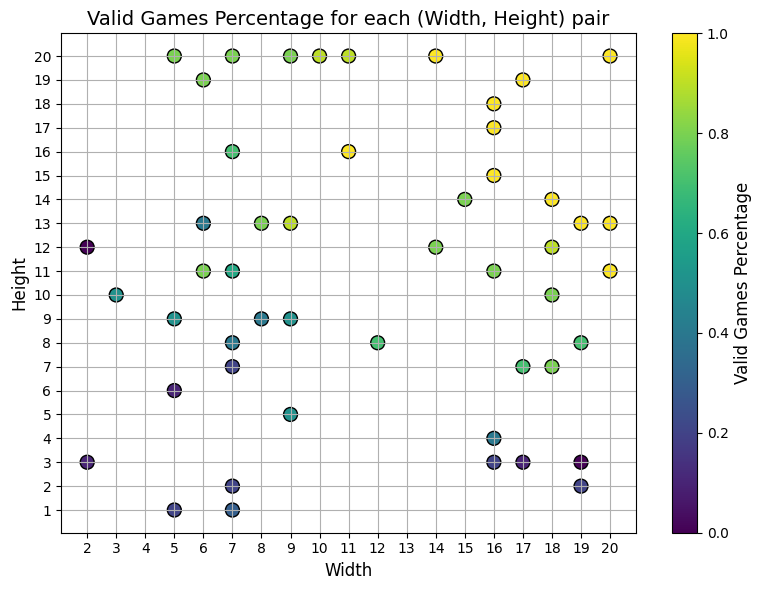

Mejores 5 de Unique Games Percentage:
Box(width=20, height=20) - 1.0
Box(width=18, height=14) - 1.0
Box(width=16, height=15) - 1.0
Box(width=14, height=20) - 1.0
Box(width=16, height=18) - 1.0
Peores 5 de Unique Games Percentage:
Box(width=5, height=6) - 0.1
Box(width=17, height=3) - 0.1
Box(width=2, height=3) - 0.1
Box(width=19, height=3) - 0.0
Box(width=2, height=12) - 0.0


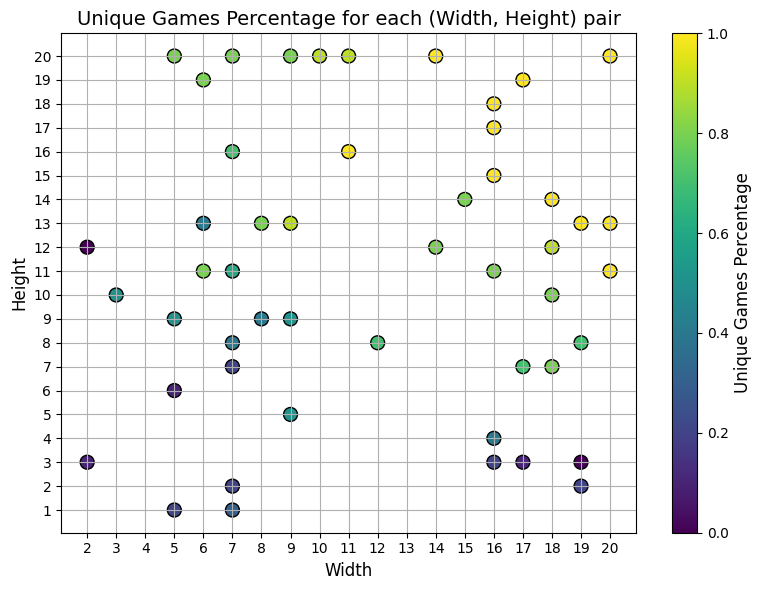

Mejores 5 de New Games Percentage:
Box(width=20, height=20) - 1.0
Box(width=18, height=14) - 1.0
Box(width=16, height=15) - 1.0
Box(width=14, height=20) - 1.0
Box(width=16, height=18) - 1.0
Peores 5 de New Games Percentage:
Box(width=5, height=6) - 0.1
Box(width=17, height=3) - 0.1
Box(width=2, height=3) - 0.1
Box(width=19, height=3) - 0.0
Box(width=2, height=12) - 0.0


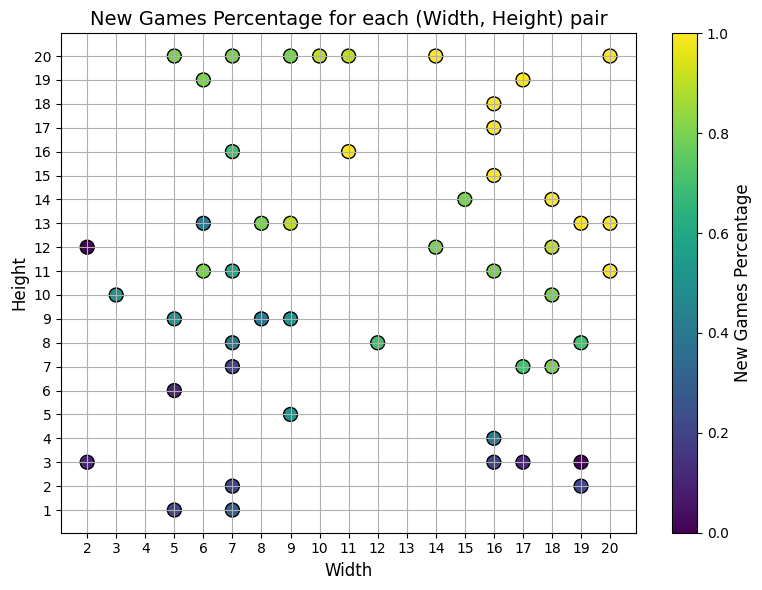

Mejores 5 de Coverage Average:
Box(width=8, height=13) - 0.6682692307692308
Box(width=18, height=12) - 0.5740740740740741
Box(width=3, height=10) - 0.5533333333333333
Box(width=18, height=7) - 0.5138888888888888
Box(width=2, height=3) - 0.5
Peores 5 de Coverage Average:
Box(width=20, height=11) - 0.2131818181818182
Box(width=6, height=11) - 0.20265151515151514
Box(width=17, height=3) - 0.19607843137254902
Box(width=19, height=3) - 0
Box(width=2, height=12) - 0


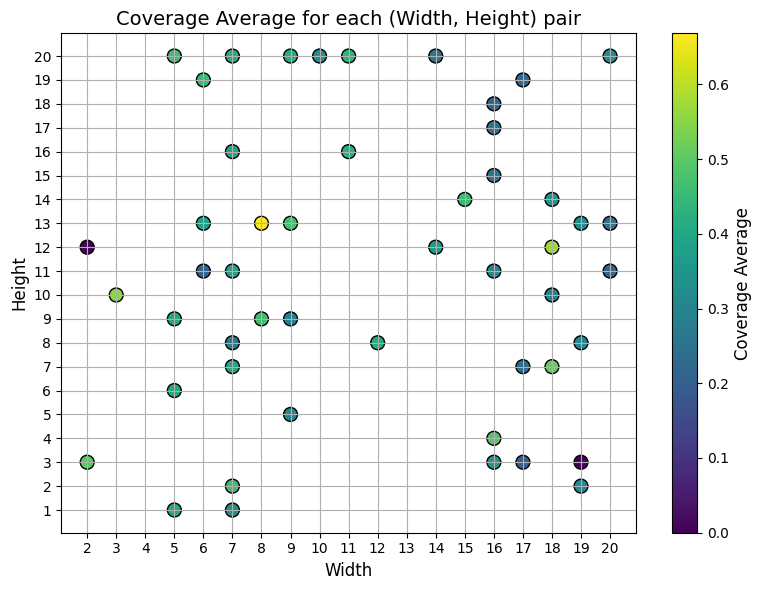

Mejores 5 de Box Count Average:
Box(width=18, height=12) - 5.444444444444445
Box(width=20, height=20) - 4.9
Box(width=15, height=14) - 4.875
Box(width=11, height=20) - 4.666666666666667
Box(width=18, height=14) - 4.5
Peores 5 de Box Count Average:
Box(width=5, height=1) - 1.0
Box(width=7, height=1) - 1.0
Box(width=19, height=2) - 1.0
Box(width=19, height=3) - 0
Box(width=2, height=12) - 0


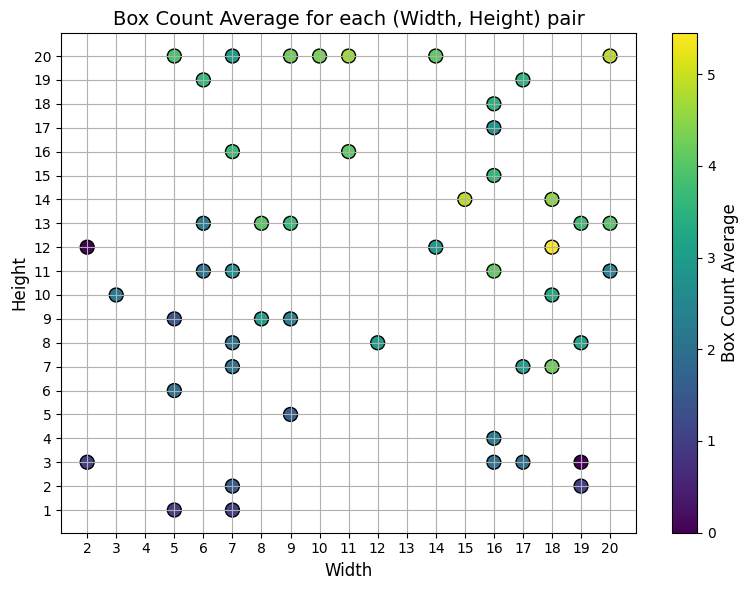

Valid Games Percentage: 0.6399999999999999
New Games Percentage: 0.6399999999999999
Unique Games Percentage: 0.6399999999999999
Coverage Average: 0.3537376069414494
Box Count Average: 2.909198412698413


In [130]:
from evaluator import Evaluator

evaluator = Evaluator(
    sequence_generator= lambda container, sequence_lenght: generate_sequence(model, torch.tensor([[container.width, container.height]],dtype=torch.float32).to(DEVICE), sequence_lenght),
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

# Promedio total de todas las métricas en todas las configuraciones
valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")



In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBinPackingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, max_dim, n_layers, n_heads, dropout=0.1):
        super(TransformerBinPackingModel, self).__init__()
        
        # Embedding para entrada (contenedor y cajas)
        self.embedding = nn.Linear(input_dim, embedding_dim)
        
        # Positional Encoding
        self.positional_encoding = self._generate_positional_encoding(100, embedding_dim)
        
        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embedding_dim, 
            nhead=n_heads, 
            dim_feedforward=hidden_dim, 
            dropout=dropout
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        
        # Proyección para obtener logits de distribuciones de width y height
        self.fc_width = nn.Linear(embedding_dim, max_dim + 1)  # +1 para incluir el token EOS
        self.fc_height = nn.Linear(embedding_dim, max_dim + 1)

    def _generate_positional_encoding(self, seq_len, dim):
        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * -(torch.log(torch.tensor(10000.0)) / dim))
        pe = torch.zeros(seq_len, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0).to(DEVICE)  # (1, seq_len, dim)
    
    def forward(self, container, target_seq=None, seq_len=100, teacher_forcing_ratio=0.5):
        """
        Args:
            container: Tensor con las dimensiones del contenedor (batch_size, input_dim).
            target_seq: Secuencia objetivo durante entrenamiento (batch_size, seq_len, input_dim).
            seq_len: Longitud máxima de secuencia durante generación.
            teacher_forcing_ratio: Probabilidad de usar teacher forcing (0.0 a 1.0).
        
        Returns:
            Logits para distribuciones de width y height.
        """
        batch_size = container.size(0)
        
        # Embedding inicial para el contenedor
        container_emb = self.embedding(container).unsqueeze(1)  # (batch_size, 1, embedding_dim)
        
        # Inicia la secuencia generada con el contenedor
        generated_seq = container_emb
        outputs_width = []
        outputs_height = []
        
        # Estado inicial de la entrada al decoder
        memory = container_emb + self.positional_encoding[:, :1, :]  # Agrega codificación posicional
        
        for t in range(seq_len):
            # Construye máscara causal para atención
            tgt_mask = torch.triu(torch.ones(t + 1, t + 1), diagonal=1).bool().to(container.device)
            
            # Agrega codificación posicional
            tgt_seq = generated_seq + self.positional_encoding[:, :generated_seq.size(1), :]
            
            # Paso del decoder
            output = self.decoder(
                tgt=tgt_seq.transpose(0, 1),  # (seq_len, batch_size, embedding_dim)
                memory=memory.transpose(0, 1),  # (1, batch_size, embedding_dim)
                tgt_mask=tgt_mask
            ).transpose(0, 1)  # (batch_size, seq_len, embedding_dim)
            
            # Proyecta para logits de width y height
            logits_width = self.fc_width(output[:, -1, :])  # (batch_size, max_dim+1)
            logits_height = self.fc_height(output[:, -1, :])  # (batch_size, max_dim+1)
            outputs_width.append(logits_width)
            outputs_height.append(logits_height)
            
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Usar la secuencia objetivo (teacher forcing)
                next_box = target_seq[:, t, :]  # (batch_size, 2)
            else:
                # Sampleo de la predicción
                prob_width = F.softmax(logits_width, dim=-1)  # (batch_size, max_dim+1)
                prob_height = F.softmax(logits_height, dim=-1)  # (batch_size, max_dim+1)
                next_width = torch.multinomial(prob_width, num_samples=1)  # (batch_size, 1)
                next_height = torch.multinomial(prob_height, num_samples=1)  # (batch_size, 1)
                next_box = torch.cat([next_width, next_height], dim=1)  # (batch_size, 2)
            
            # Embedding del próximo paso
            next_box_emb = self.embedding(next_box.float())
            generated_seq = torch.cat([generated_seq, next_box_emb.unsqueeze(1)], dim=1)
        
        # Apilar las salidas
        logits_width = torch.stack(outputs_width, dim=1)  # (batch_size, seq_len, max_dim+1)
        logits_height = torch.stack(outputs_height, dim=1)  # (batch_size, seq_len, max_dim+1)
        return logits_width, logits_height


In [80]:
# Datos de entrenamiento
criterion = AdvancedBingPackingProblemLoss(MAX_DIM, DEVICE, exceeding_area_penalty_weight=0)

input_dim = 2
embedding_dim = 4
hidden_dim = 20
n_layers = 1
n_heads = 1
dropout = 0

# Modelo
model = TransformerBinPackingModel(input_dim, embedding_dim, hidden_dim, MAX_DIM, n_layers, n_heads, dropout)
model.to(DEVICE)
# Hiperparámetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train(model,criterion, optimizer,epochs=2000)

Epoch 1/2000, Train Loss: 5.675316333770752
Epoch 1/2000, Val Loss: 5.361516952514648
Epoch 2/2000, Train Loss: 5.3138768672943115
Epoch 2/2000, Val Loss: 5.1591901779174805
Epoch 3/2000, Train Loss: 5.115336656570435
Epoch 3/2000, Val Loss: 4.999125957489014
Epoch 4/2000, Train Loss: 4.9420998096466064
Epoch 4/2000, Val Loss: 4.8199920654296875
Epoch 5/2000, Train Loss: 4.774700403213501
Epoch 5/2000, Val Loss: 4.656139373779297
Epoch 6/2000, Train Loss: 4.612017631530762
Epoch 6/2000, Val Loss: 4.500476360321045
Epoch 7/2000, Train Loss: 4.463470220565796
Epoch 7/2000, Val Loss: 4.366821765899658
Epoch 8/2000, Train Loss: 4.332824230194092
Epoch 8/2000, Val Loss: 4.25224494934082
Epoch 9/2000, Train Loss: 4.2282469272613525
Epoch 9/2000, Val Loss: 4.164042949676514
Epoch 10/2000, Train Loss: 4.14487361907959
Epoch 10/2000, Val Loss: 4.092168807983398
Epoch 11/2000, Train Loss: 4.074598073959351
Epoch 11/2000, Val Loss: 4.0411458015441895
Epoch 12/2000, Train Loss: 4.025310277938843
E

Mejores 5 de Valid Games Percentage:
Box(width=17, height=10) - 1.0
Box(width=15, height=12) - 1.0
Box(width=19, height=13) - 1.0
Box(width=12, height=13) - 1.0
Box(width=18, height=13) - 1.0
Peores 5 de Valid Games Percentage:
Box(width=2, height=6) - 0.1
Box(width=5, height=1) - 0.0
Box(width=2, height=1) - 0.0
Box(width=1, height=4) - 0.0
Box(width=5, height=3) - 0.0


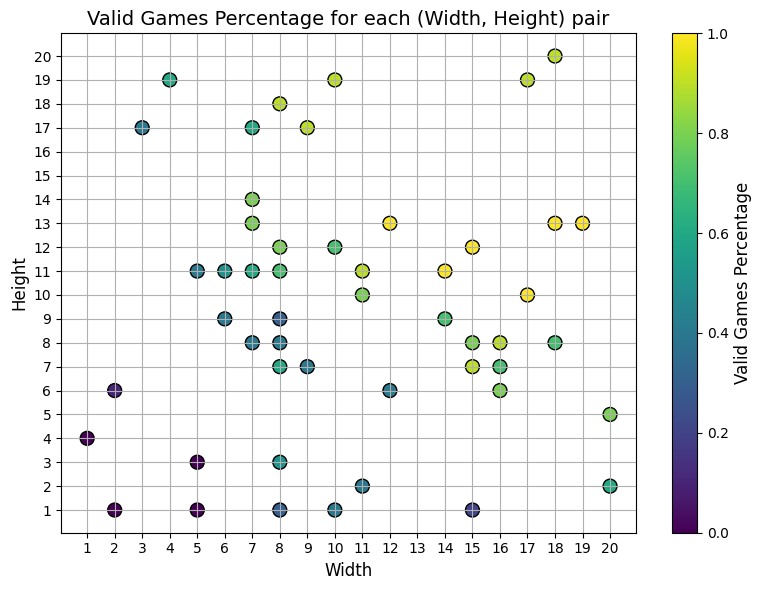

Mejores 5 de Unique Games Percentage:
Box(width=17, height=10) - 1.0
Box(width=15, height=12) - 1.0
Box(width=19, height=13) - 1.0
Box(width=12, height=13) - 1.0
Box(width=18, height=13) - 1.0
Peores 5 de Unique Games Percentage:
Box(width=2, height=6) - 0.1
Box(width=5, height=1) - 0.0
Box(width=2, height=1) - 0.0
Box(width=1, height=4) - 0.0
Box(width=5, height=3) - 0.0


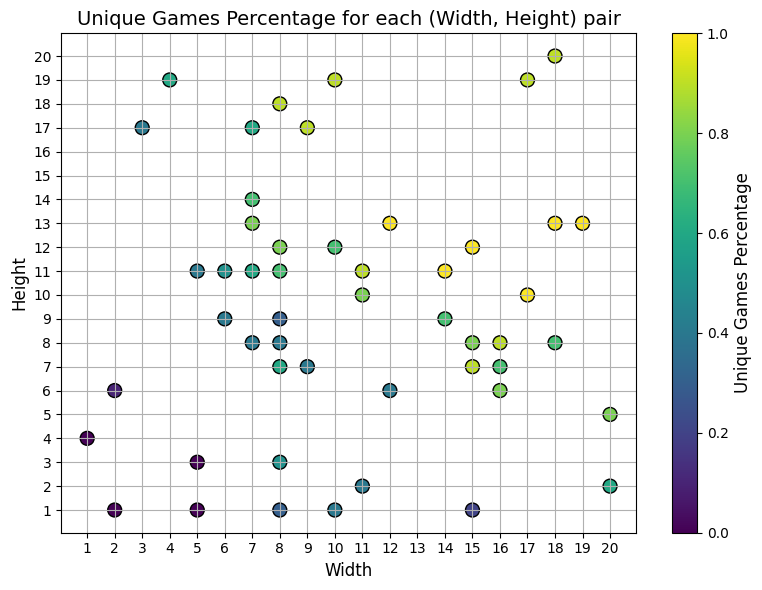

Mejores 5 de New Games Percentage:
Box(width=17, height=10) - 1.0
Box(width=15, height=12) - 1.0
Box(width=19, height=13) - 1.0
Box(width=12, height=13) - 1.0
Box(width=18, height=13) - 1.0
Peores 5 de New Games Percentage:
Box(width=2, height=6) - 0.1
Box(width=5, height=1) - 0.0
Box(width=2, height=1) - 0.0
Box(width=1, height=4) - 0.0
Box(width=5, height=3) - 0.0


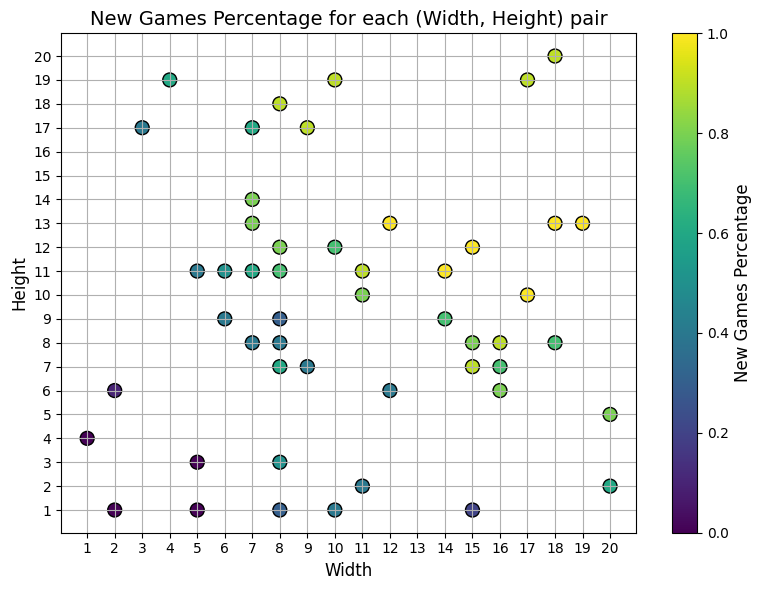

Mejores 5 de Coverage Average:
Box(width=6, height=9) - 0.5833333333333333
Box(width=7, height=11) - 0.5497835497835498
Box(width=4, height=19) - 0.5109649122807017
Box(width=7, height=8) - 0.5089285714285714
Box(width=6, height=11) - 0.5
Peores 5 de Coverage Average:
Box(width=17, height=19) - 0.11936704506363949
Box(width=5, height=1) - 0
Box(width=2, height=1) - 0
Box(width=1, height=4) - 0
Box(width=5, height=3) - 0


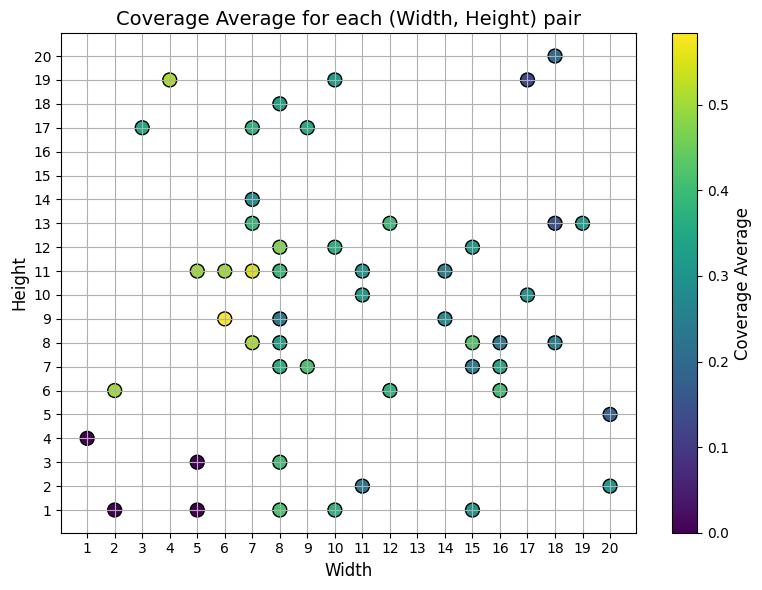

Mejores 5 de Box Count Average:
Box(width=19, height=13) - 4.0
Box(width=17, height=10) - 3.8
Box(width=10, height=12) - 3.5714285714285716
Box(width=18, height=20) - 3.5555555555555554
Box(width=12, height=13) - 3.5
Peores 5 de Box Count Average:
Box(width=11, height=2) - 1.0
Box(width=5, height=1) - 0
Box(width=2, height=1) - 0
Box(width=1, height=4) - 0
Box(width=5, height=3) - 0


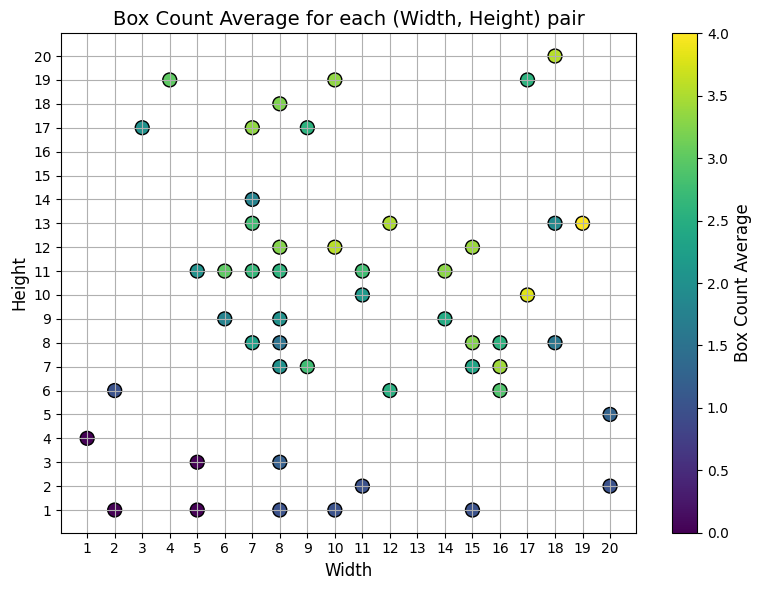

Valid Games Percentage: 0.6159999999999999
New Games Percentage: 0.6159999999999999
Unique Games Percentage: 0.6139999999999999
Coverage Average: 0.3203739976654512
Box Count Average: 2.2312063492063494


In [81]:
from evaluator import Evaluator

def lambda_sequence_generator(c1, max_seq_len=10):
    return generate_sequence(model, torch.tensor([[c1.width, c1.height]],dtype=torch.float32).to(DEVICE), max_seq_len)

evaluator = Evaluator(
    sequence_generator= lambda_sequence_generator,
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

# Promedio total de todas las métricas en todas las configuraciones
valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")

In [122]:
# Datos de entrenamiento
criterion = AdvancedBingPackingProblemLoss(MAX_DIM, DEVICE, exceeding_area_penalty_weight=0.4)

input_dim = 2
embedding_dim = 4
hidden_dim = 20
n_layers = 1
n_heads = 1
dropout = 0

# Modelo
model = TransformerBinPackingModel(input_dim, embedding_dim, hidden_dim, MAX_DIM, n_layers, n_heads, dropout)
model.to(DEVICE)
# Hiperparámetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train(model,criterion, optimizer,epochs=2000)

Epoch 1/2000, Train Loss: 6.401873588562012
Epoch 1/2000, Val Loss: 6.206512451171875
Epoch 2/2000, Train Loss: 6.149957656860352
Epoch 2/2000, Val Loss: 5.993336200714111
Epoch 3/2000, Train Loss: 5.941664695739746
Epoch 3/2000, Val Loss: 5.797492980957031
Epoch 4/2000, Train Loss: 5.743484973907471
Epoch 4/2000, Val Loss: 5.607372283935547
Epoch 5/2000, Train Loss: 5.563481569290161
Epoch 5/2000, Val Loss: 5.436107635498047
Epoch 6/2000, Train Loss: 5.397094964981079
Epoch 6/2000, Val Loss: 5.276292324066162
Epoch 7/2000, Train Loss: 5.239521026611328
Epoch 7/2000, Val Loss: 5.127455711364746
Epoch 8/2000, Train Loss: 5.08967924118042
Epoch 8/2000, Val Loss: 4.981255531311035
Epoch 9/2000, Train Loss: 4.947088003158569
Epoch 9/2000, Val Loss: 4.846199989318848
Epoch 10/2000, Train Loss: 4.811654329299927
Epoch 10/2000, Val Loss: 4.718504905700684
Epoch 11/2000, Train Loss: 4.685845851898193
Epoch 11/2000, Val Loss: 4.599152088165283
Epoch 12/2000, Train Loss: 4.568750381469727
Epoch 

Mejores 5 de Valid Games Percentage:
Box(width=20, height=19) - 1.0
Box(width=20, height=9) - 1.0
Box(width=10, height=19) - 1.0
Box(width=20, height=11) - 1.0
Box(width=9, height=19) - 1.0
Peores 5 de Valid Games Percentage:
Box(width=8, height=2) - 0.1
Box(width=6, height=9) - 0.0
Box(width=3, height=2) - 0.0
Box(width=1, height=7) - 0.0
Box(width=3, height=5) - 0.0


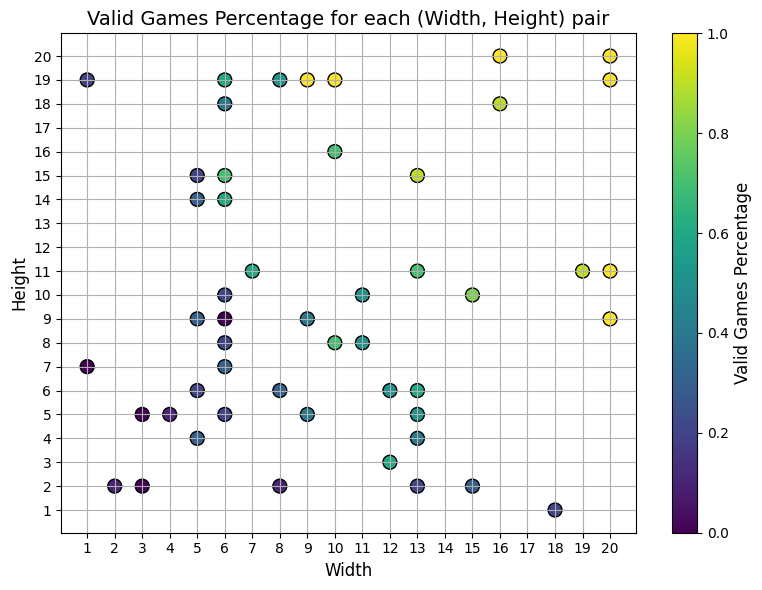

Mejores 5 de Unique Games Percentage:
Box(width=20, height=19) - 1.0
Box(width=20, height=9) - 1.0
Box(width=10, height=19) - 1.0
Box(width=20, height=11) - 1.0
Box(width=9, height=19) - 1.0
Peores 5 de Unique Games Percentage:
Box(width=8, height=2) - 0.1
Box(width=6, height=9) - 0.0
Box(width=3, height=2) - 0.0
Box(width=1, height=7) - 0.0
Box(width=3, height=5) - 0.0


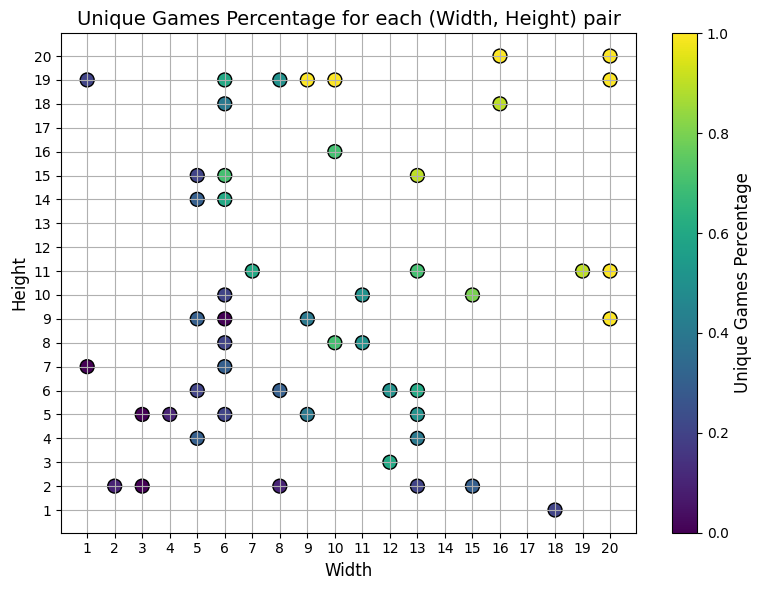

Mejores 5 de New Games Percentage:
Box(width=20, height=19) - 1.0
Box(width=20, height=9) - 1.0
Box(width=10, height=19) - 1.0
Box(width=20, height=11) - 1.0
Box(width=9, height=19) - 1.0
Peores 5 de New Games Percentage:
Box(width=8, height=2) - 0.1
Box(width=6, height=9) - 0.0
Box(width=3, height=2) - 0.0
Box(width=1, height=7) - 0.0
Box(width=3, height=5) - 0.0


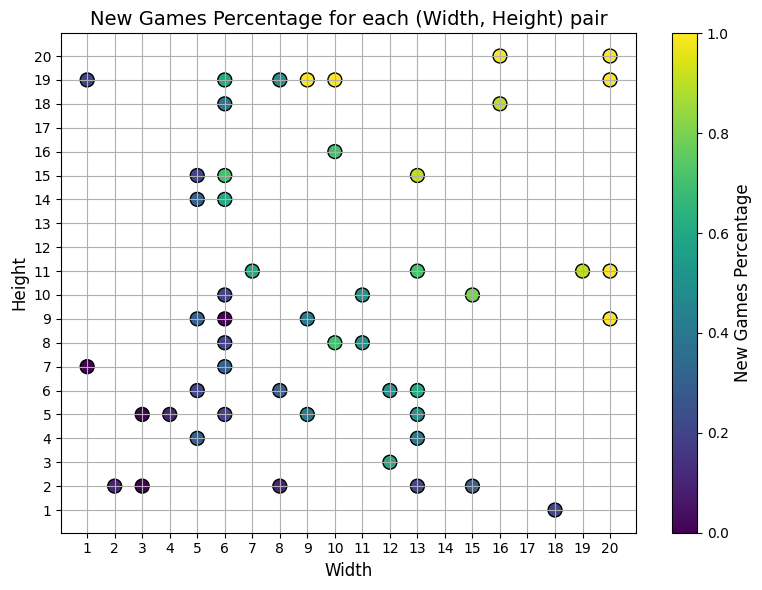

Mejores 5 de Coverage Average:
Box(width=6, height=8) - 0.84375
Box(width=5, height=9) - 0.7333333333333334
Box(width=9, height=9) - 0.7222222222222222
Box(width=13, height=6) - 0.6602564102564102
Box(width=11, height=8) - 0.6522727272727273
Peores 5 de Coverage Average:
Box(width=20, height=19) - 0.1918421052631579
Box(width=6, height=9) - 0
Box(width=3, height=2) - 0
Box(width=1, height=7) - 0
Box(width=3, height=5) - 0


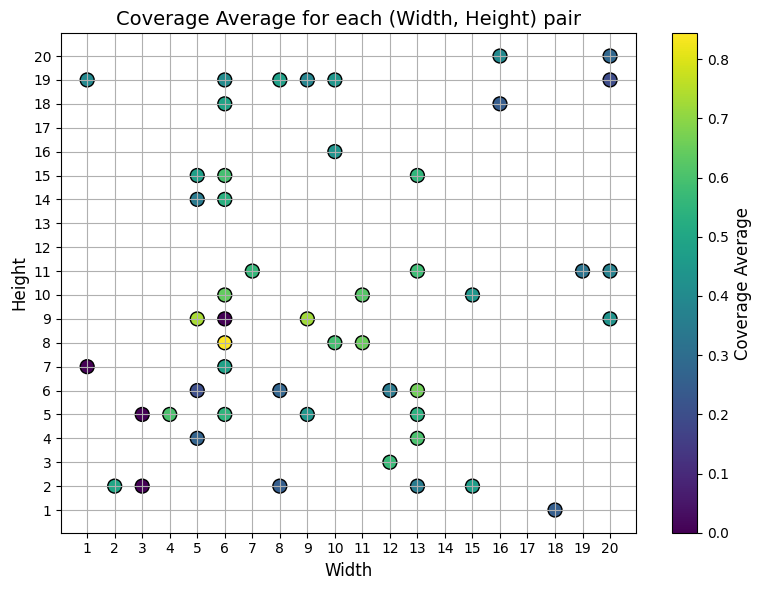

Mejores 5 de Box Count Average:
Box(width=6, height=8) - 5.0
Box(width=6, height=10) - 5.0
Box(width=8, height=19) - 5.0
Box(width=16, height=20) - 4.9
Box(width=10, height=16) - 4.714285714285714
Peores 5 de Box Count Average:
Box(width=5, height=6) - 1.0
Box(width=6, height=9) - 0
Box(width=3, height=2) - 0
Box(width=1, height=7) - 0
Box(width=3, height=5) - 0


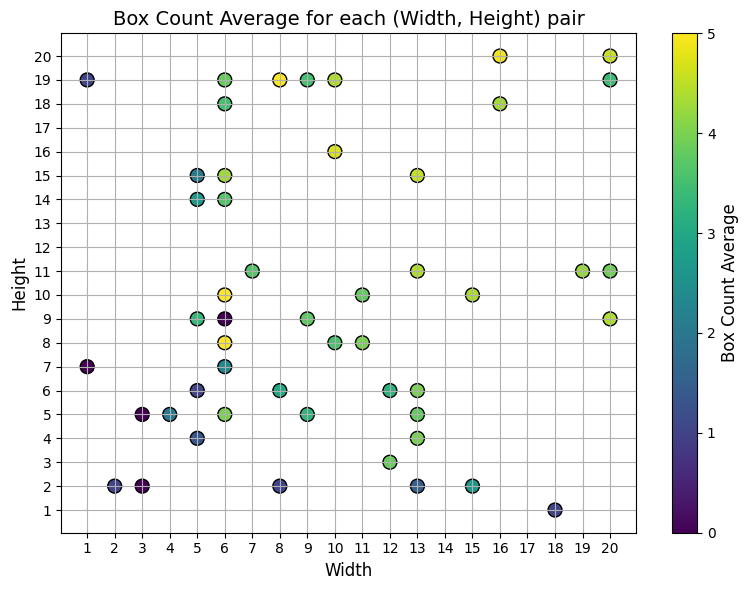

Valid Games Percentage: 0.48200000000000004
New Games Percentage: 0.48200000000000004
Unique Games Percentage: 0.48200000000000004
Coverage Average: 0.4293490809409887
Box Count Average: 3.1343888888888887


In [128]:
from evaluator import Evaluator

def lambda_sequence_generator(c1, max_seq_len=10):
    return generate_sequence(model, torch.tensor([[c1.width, c1.height]],dtype=torch.float32).to(DEVICE), max_seq_len)

evaluator = Evaluator(
    sequence_generator= lambda_sequence_generator,
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

# Promedio total de todas las métricas en todas las configuraciones
valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")

In [129]:
def generate_sequence_heuristics(model, container, max_seq_len=10):
    """
    Genera una secuencia de cajas a partir de un contenedor utilizando el modelo,
    restringiendo el muestreo a dimensiones válidas (ancho y alto menores o iguales
    a las dimensiones del contenedor).

    Args:
        model: El modelo entrenado para generar secuencias.
        container: Tensor con las dimensiones del contenedor (batch_size=1, input_dim=2).
        max_seq_len: Longitud máxima de la secuencia generada.

    Returns:
        List[Box]: Lista de cajas generadas como instancias de la clase `Box`.
    """
    model.eval()  # Poner el modelo en modo evaluación
    container = container.to(DEVICE)  # Asegurarse de que el contenedor esté en el mismo dispositivo
    generated_boxes = []  # Lista para almacenar las cajas generadas
    
    # Extraer las dimensiones del contenedor
    container_width, container_height = container[0].tolist()  # batch_size=1 asumido

    with torch.no_grad():  # Deshabilitar cálculo de gradientes
        logits_width, logits_height = model(container, target_seq=None, seq_len=max_seq_len, teacher_forcing_ratio=0.0)

        for t in range(max_seq_len):
            # Obtener logits del tiempo actual
            prob_width = F.softmax(logits_width[:, t, :], dim=-1)  # (batch_size, max_dim+1)
            prob_height = F.softmax(logits_height[:, t, :], dim=-1)  # (batch_size, max_dim+1)

            # Crear máscaras para dimensiones válidas
            mask_width = torch.arange(prob_width.size(-1), device=prob_width.device) <= container_width
            mask_height = torch.arange(prob_height.size(-1), device=prob_height.device) <= container_height

            # Aplicar máscara a las probabilidades
            prob_width = prob_width * mask_width  # Dimensiones inválidas tendrán probabilidad 0
            prob_height = prob_height * mask_height

            # Renormalizar para que las probabilidades sumen 1
            prob_width = prob_width / prob_width.sum(dim=-1, keepdim=True)
            prob_height = prob_height / prob_height.sum(dim=-1, keepdim=True)

            # Samplear dimensiones width y height
            sampled_width = torch.multinomial(prob_width, num_samples=1).item()  # Convertir a int
            sampled_height = torch.multinomial(prob_height, num_samples=1).item()  # Convertir a int

            # Crear instancia de Box y agregarla a la lista
            if sampled_width == 0 and sampled_height == 0:  # EOS token
                break
            generated_boxes.append(Box(sampled_width, sampled_height))

            # Reducir el espacio disponible en el contenedor
            container_width -= sampled_width
            container_height -= sampled_height

            # Si no hay espacio suficiente, detener la generación
            if container_width <= 0 or container_height <= 0:
                break

    return generated_boxes


Epoch 1/2000, Train Loss: 6.0712456703186035
Epoch 1/2000, Val Loss: 6.042359352111816
Epoch 2/2000, Train Loss: 6.02973484992981
Epoch 2/2000, Val Loss: 6.005583763122559
Epoch 3/2000, Train Loss: 5.985106468200684
Epoch 3/2000, Val Loss: 5.974180221557617
Epoch 4/2000, Train Loss: 5.943418741226196
Epoch 4/2000, Val Loss: 5.901975631713867
Epoch 5/2000, Train Loss: 5.88477897644043
Epoch 5/2000, Val Loss: 5.880837440490723
Epoch 6/2000, Train Loss: 5.86279559135437
Epoch 6/2000, Val Loss: 5.879541873931885
Epoch 7/2000, Train Loss: 5.815877914428711
Epoch 7/2000, Val Loss: 5.769653797149658
Epoch 8/2000, Train Loss: 5.744453191757202
Epoch 8/2000, Val Loss: 5.752674102783203
Epoch 9/2000, Train Loss: 5.69120979309082
Epoch 9/2000, Val Loss: 5.634903907775879
Epoch 10/2000, Train Loss: 5.674152374267578
Epoch 10/2000, Val Loss: 5.546474456787109
Epoch 11/2000, Train Loss: 5.523940324783325
Epoch 11/2000, Val Loss: 5.594640731811523
Epoch 12/2000, Train Loss: 5.469321250915527
Epoch 12

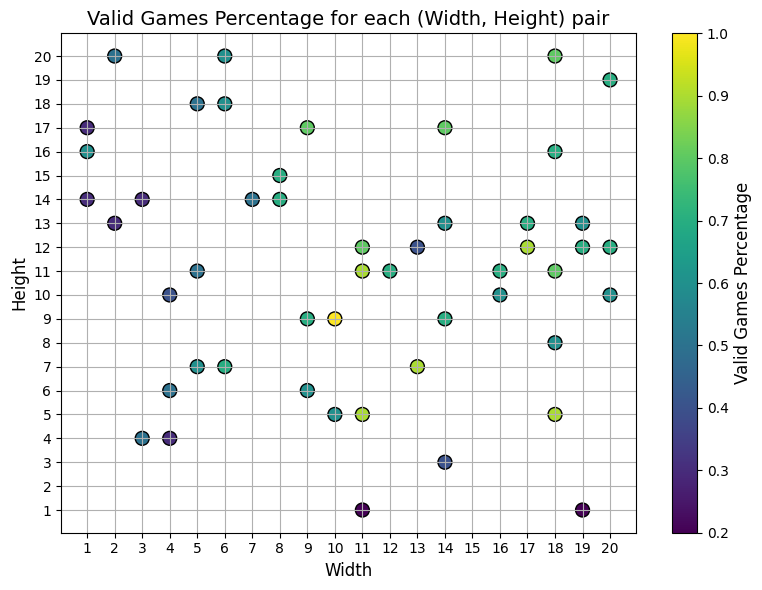

Mejores 5 de Unique Games Percentage:
Box(width=10, height=9) - 1.0
Box(width=11, height=5) - 0.9
Box(width=11, height=11) - 0.9
Box(width=17, height=12) - 0.9
Box(width=18, height=5) - 0.9
Peores 5 de Unique Games Percentage:
Box(width=1, height=17) - 0.3
Box(width=1, height=14) - 0.3
Box(width=4, height=4) - 0.3
Box(width=11, height=1) - 0.2
Box(width=19, height=1) - 0.2


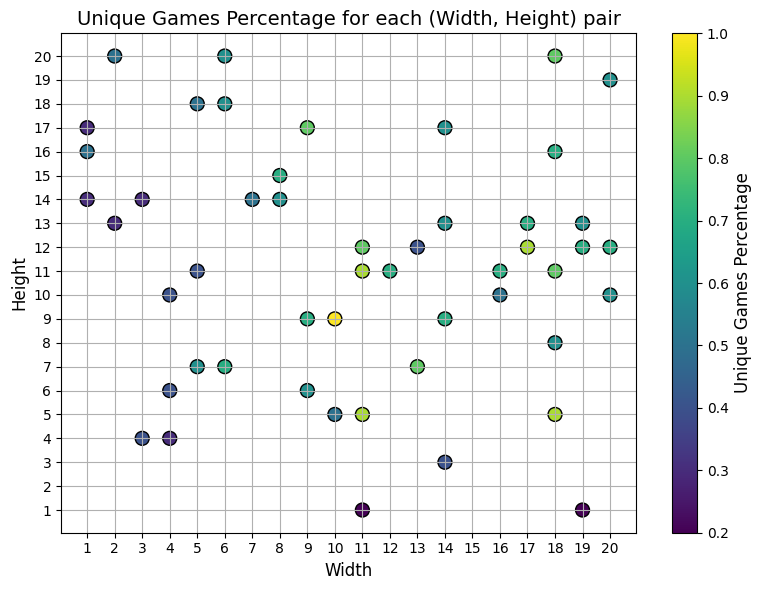

Mejores 5 de New Games Percentage:
Box(width=10, height=9) - 1.0
Box(width=11, height=5) - 0.9
Box(width=11, height=11) - 0.9
Box(width=17, height=12) - 0.9
Box(width=18, height=5) - 0.9
Peores 5 de New Games Percentage:
Box(width=1, height=17) - 0.3
Box(width=1, height=14) - 0.3
Box(width=4, height=4) - 0.3
Box(width=11, height=1) - 0.2
Box(width=19, height=1) - 0.2


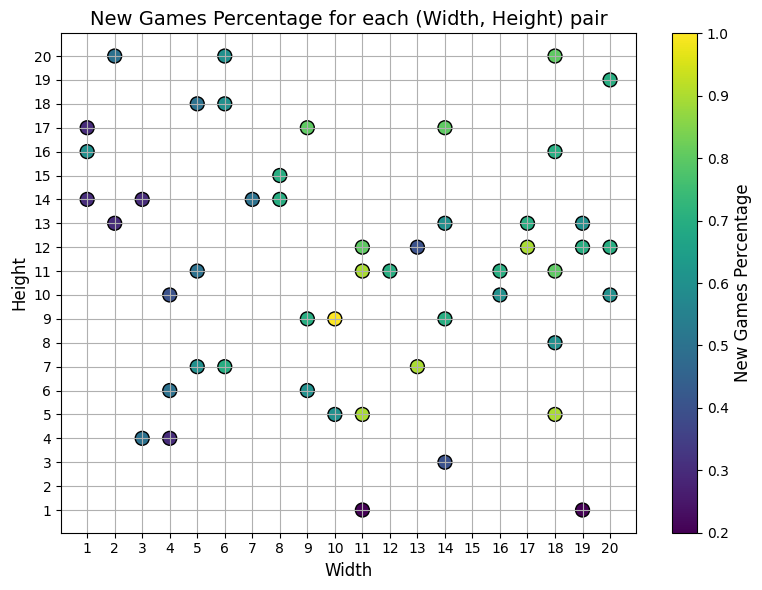

Mejores 5 de Coverage Average:
Box(width=3, height=4) - 0.45
Box(width=5, height=7) - 0.37142857142857144
Box(width=11, height=1) - 0.36363636363636365
Box(width=19, height=1) - 0.3421052631578947
Box(width=1, height=14) - 0.3333333333333333
Peores 5 de Coverage Average:
Box(width=14, height=13) - 0.07142857142857144
Box(width=20, height=19) - 0.07030075187969924
Box(width=14, height=17) - 0.06722689075630252
Box(width=18, height=20) - 0.06284722222222222
Box(width=18, height=16) - 0.04712301587301587


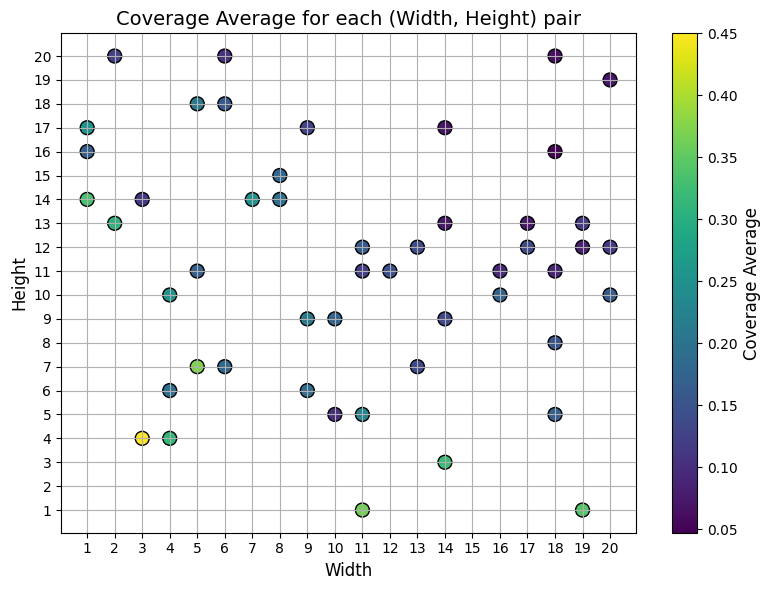

Mejores 5 de Box Count Average:
Box(width=20, height=10) - 2.3333333333333335
Box(width=11, height=12) - 2.25
Box(width=20, height=19) - 1.8571428571428572
Box(width=18, height=8) - 1.8333333333333333
Box(width=19, height=13) - 1.8333333333333333
Peores 5 de Box Count Average:
Box(width=1, height=14) - 1.0
Box(width=2, height=13) - 1.0
Box(width=1, height=17) - 1.0
Box(width=1, height=16) - 1.0
Box(width=3, height=14) - 1.0


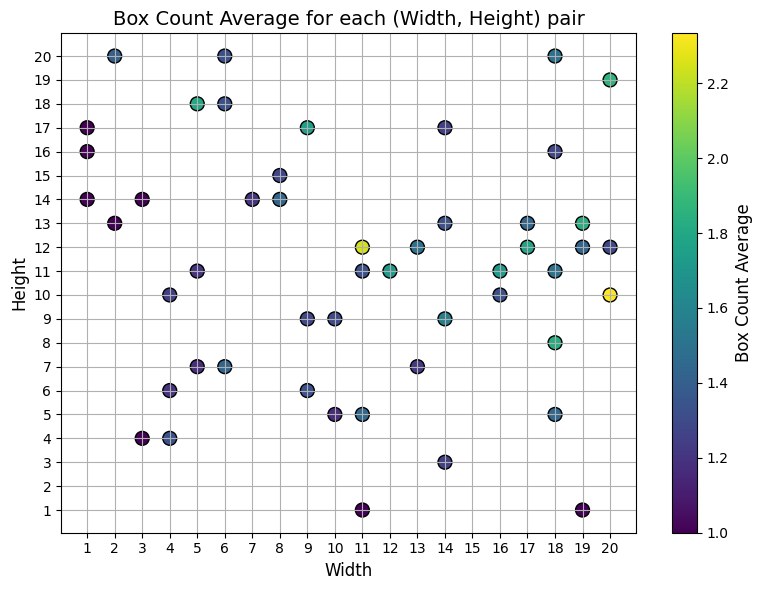

Valid Games Percentage: 0.612
New Games Percentage: 0.612
Unique Games Percentage: 0.59
Coverage Average: 0.17782792648757917
Box Count Average: 1.3923968253968257


In [144]:
# Datos de entrenamiento
criterion = AdvancedBingPackingProblemLoss(MAX_DIM, DEVICE, exceeding_area_penalty_weight=0.4)

input_dim = 2
embedding_dim = 2
hidden_dim = 100
n_layers = 1
dropout = 0

# Modelo
model = AutoRegressiveBinPackingModel(input_dim, embedding_dim, hidden_dim, MAX_DIM, n_layers, dropout)
model.to(DEVICE)
# Hiperparámetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model,criterion, optimizer,epochs=2000, teacher_forcing_initial_ratio=0.88)


def lambda_sequence_generator_heuristics(c1, max_seq_len=10):
    return generate_sequence_heuristics(model, torch.tensor([[c1.width, c1.height]],dtype=torch.float32).to(DEVICE), max_seq_len)

evaluator = Evaluator(
    sequence_generator= lambda_sequence_generator_heuristics,
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

# Promedio total de todas las métricas en todas las configuraciones
valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")

Epoch 1/2000, Train Loss: 6.506857633590698
Epoch 1/2000, Val Loss: 6.3752899169921875
Epoch 2/2000, Train Loss: 6.281635284423828
Epoch 2/2000, Val Loss: 6.1603593826293945
Epoch 3/2000, Train Loss: 6.084886074066162
Epoch 3/2000, Val Loss: 5.954097747802734
Epoch 4/2000, Train Loss: 5.886943101882935
Epoch 4/2000, Val Loss: 5.747262001037598
Epoch 5/2000, Train Loss: 5.70530104637146
Epoch 5/2000, Val Loss: 5.575085639953613
Epoch 6/2000, Train Loss: 5.536111354827881
Epoch 6/2000, Val Loss: 5.415892601013184
Epoch 7/2000, Train Loss: 5.378407001495361
Epoch 7/2000, Val Loss: 5.265263557434082
Epoch 8/2000, Train Loss: 5.229080438613892
Epoch 8/2000, Val Loss: 5.121209144592285
Epoch 9/2000, Train Loss: 5.084198713302612
Epoch 9/2000, Val Loss: 4.980422019958496
Epoch 10/2000, Train Loss: 4.945742607116699
Epoch 10/2000, Val Loss: 4.845179557800293
Epoch 11/2000, Train Loss: 4.810598134994507
Epoch 11/2000, Val Loss: 4.71312141418457
Epoch 12/2000, Train Loss: 4.680891752243042
Epoch

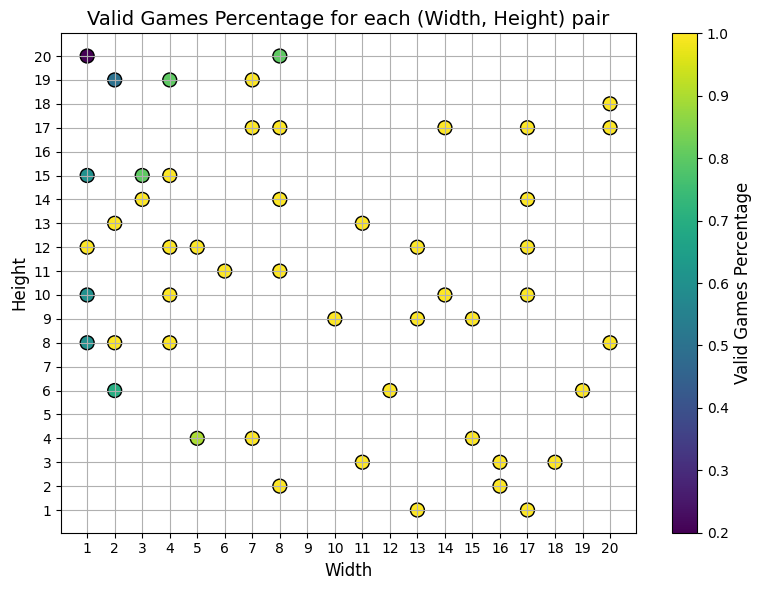

Mejores 5 de Unique Games Percentage:
Box(width=20, height=18) - 1.0
Box(width=10, height=9) - 1.0
Box(width=4, height=15) - 1.0
Box(width=20, height=8) - 1.0
Box(width=20, height=17) - 1.0
Peores 5 de Unique Games Percentage:
Box(width=1, height=15) - 0.5
Box(width=1, height=8) - 0.5
Box(width=1, height=10) - 0.4
Box(width=2, height=19) - 0.4
Box(width=1, height=20) - 0.2


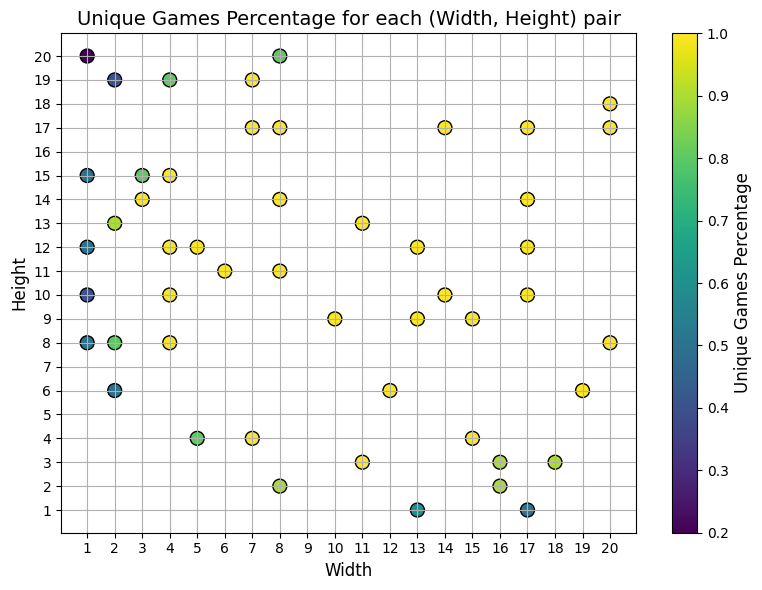

Mejores 5 de New Games Percentage:
Box(width=20, height=18) - 1.0
Box(width=10, height=9) - 1.0
Box(width=4, height=15) - 1.0
Box(width=20, height=8) - 1.0
Box(width=20, height=17) - 1.0
Peores 5 de New Games Percentage:
Box(width=1, height=15) - 0.6
Box(width=1, height=8) - 0.6
Box(width=1, height=10) - 0.6
Box(width=2, height=19) - 0.5
Box(width=1, height=20) - 0.2


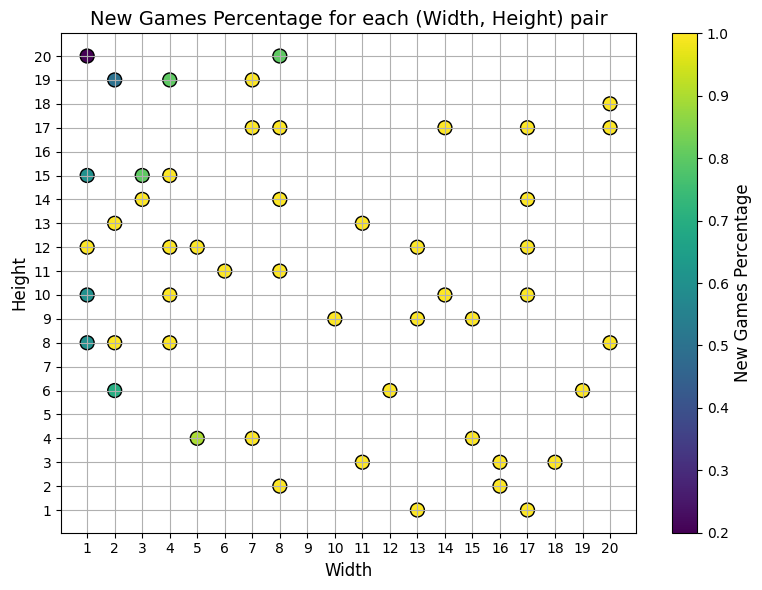

Mejores 5 de Coverage Average:
Box(width=2, height=8) - 0.46875
Box(width=7, height=4) - 0.3821428571428571
Box(width=1, height=8) - 0.375
Box(width=4, height=8) - 0.371875
Box(width=4, height=10) - 0.3675
Peores 5 de Coverage Average:
Box(width=17, height=17) - 0.17404844290657437
Box(width=2, height=19) - 0.1526315789473684
Box(width=4, height=19) - 0.12335526315789475
Box(width=7, height=19) - 0.08646616541353383
Box(width=8, height=20) - 0.07031250000000001


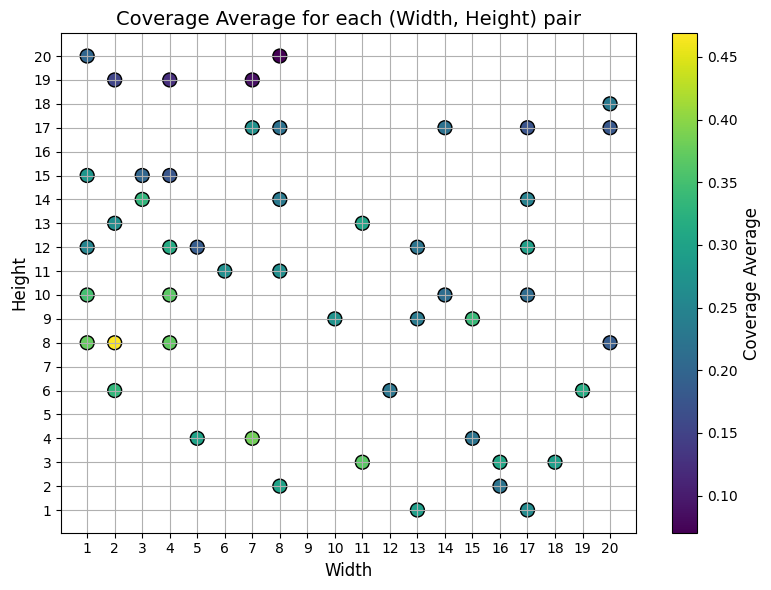

Mejores 5 de Box Count Average:
Box(width=17, height=12) - 3.3
Box(width=14, height=17) - 3.3
Box(width=17, height=10) - 3.3
Box(width=8, height=17) - 3.2
Box(width=15, height=9) - 3.1
Peores 5 de Box Count Average:
Box(width=13, height=1) - 1.0
Box(width=1, height=15) - 1.0
Box(width=17, height=1) - 1.0
Box(width=1, height=12) - 1.0
Box(width=1, height=20) - 1.0


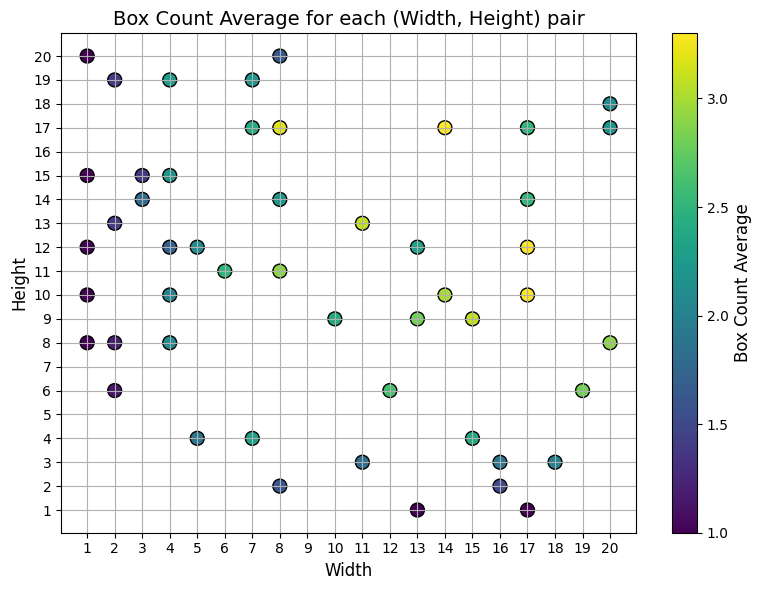

Valid Games Percentage: 0.9300000000000002
New Games Percentage: 0.9300000000000002
Unique Games Percentage: 0.8719999999999998
Coverage Average: 0.2588954115369124
Box Count Average: 2.08563492063492


In [143]:
# Datos de entrenamiento
criterion = AdvancedBingPackingProblemLoss(MAX_DIM, DEVICE, exceeding_area_penalty_weight=0)

input_dim = 2
embedding_dim = 4
hidden_dim = 20
n_layers = 1
n_heads = 1
dropout = 0

# Modelo
model = TransformerBinPackingModel(input_dim, embedding_dim, hidden_dim, MAX_DIM, n_layers, n_heads, dropout)
model.to(DEVICE)
# Hiperparámetros
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train(model,criterion, optimizer,epochs=2000)


evaluator = Evaluator(
    sequence_generator= lambda_sequence_generator_heuristics,
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

# Promedio total de todas las métricas en todas las configuraciones
valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")